Output()

HTML(value='Set quantization parameters:')

Button(button_style='info', description='Generate Palettes', disabled=True, style=ButtonStyle())

Output()

RadioButtons(description='Choose Palette:', disabled=True, options=('PIL', 'K-Means', 'MeanShift'), value='PIL…

HTML(value='Set post-processing parameters:')

Button(button_style='success', description='Process Final Image', disabled=True, style=ButtonStyle())

Output()

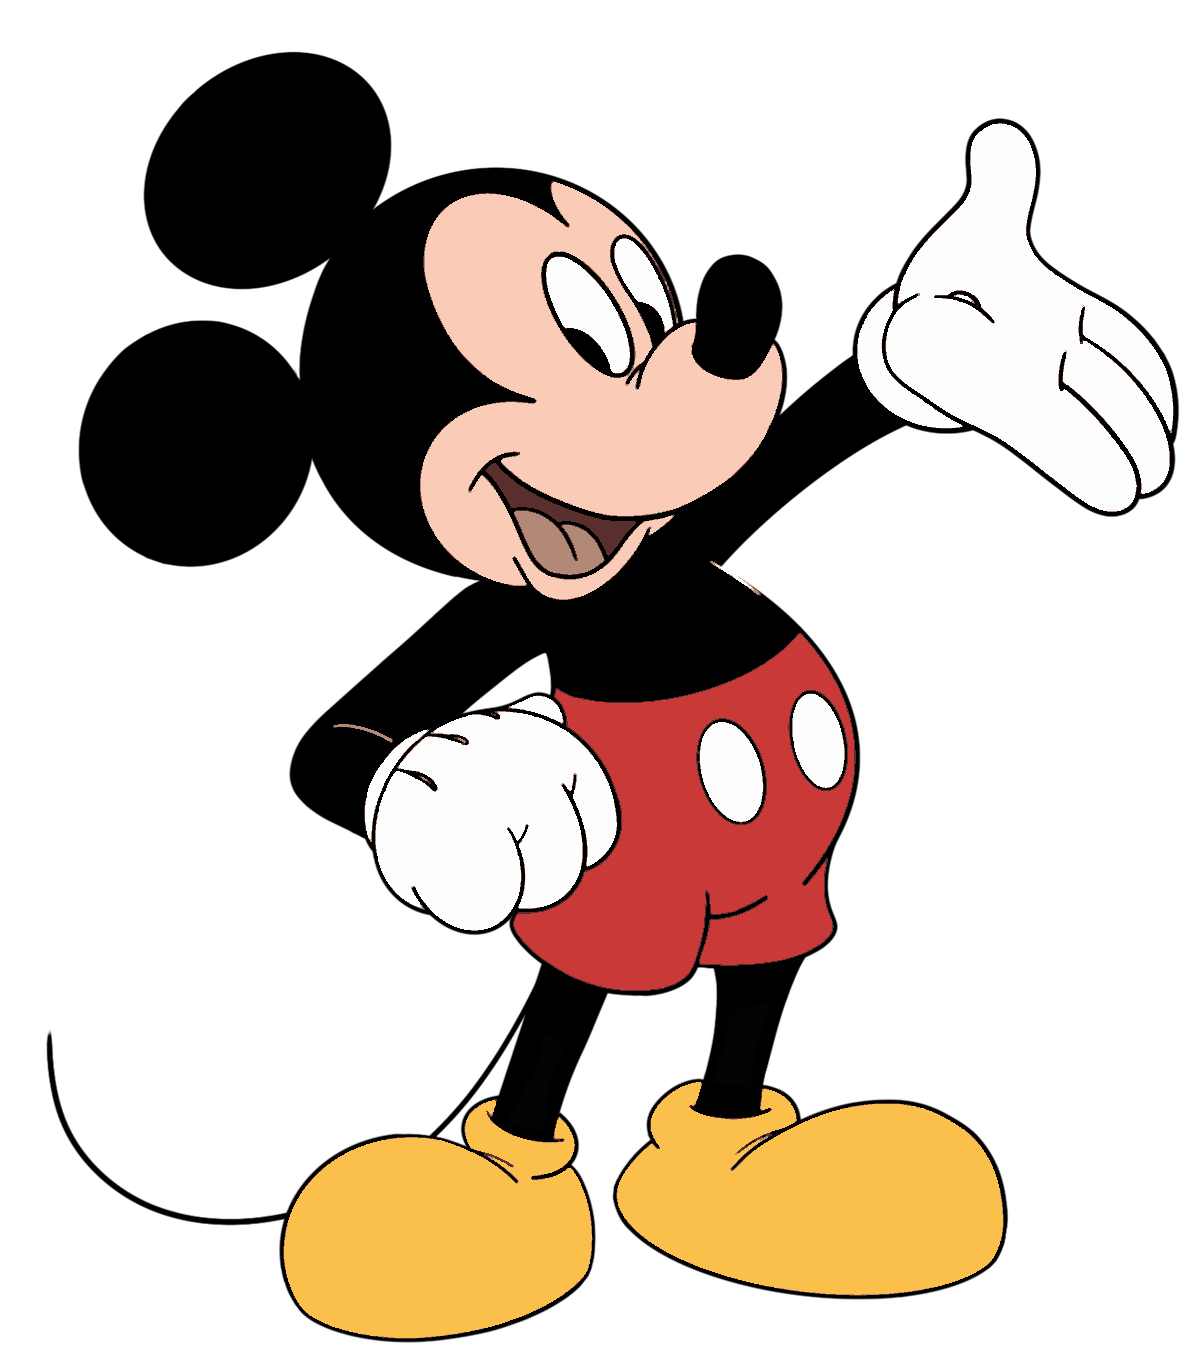

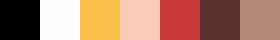

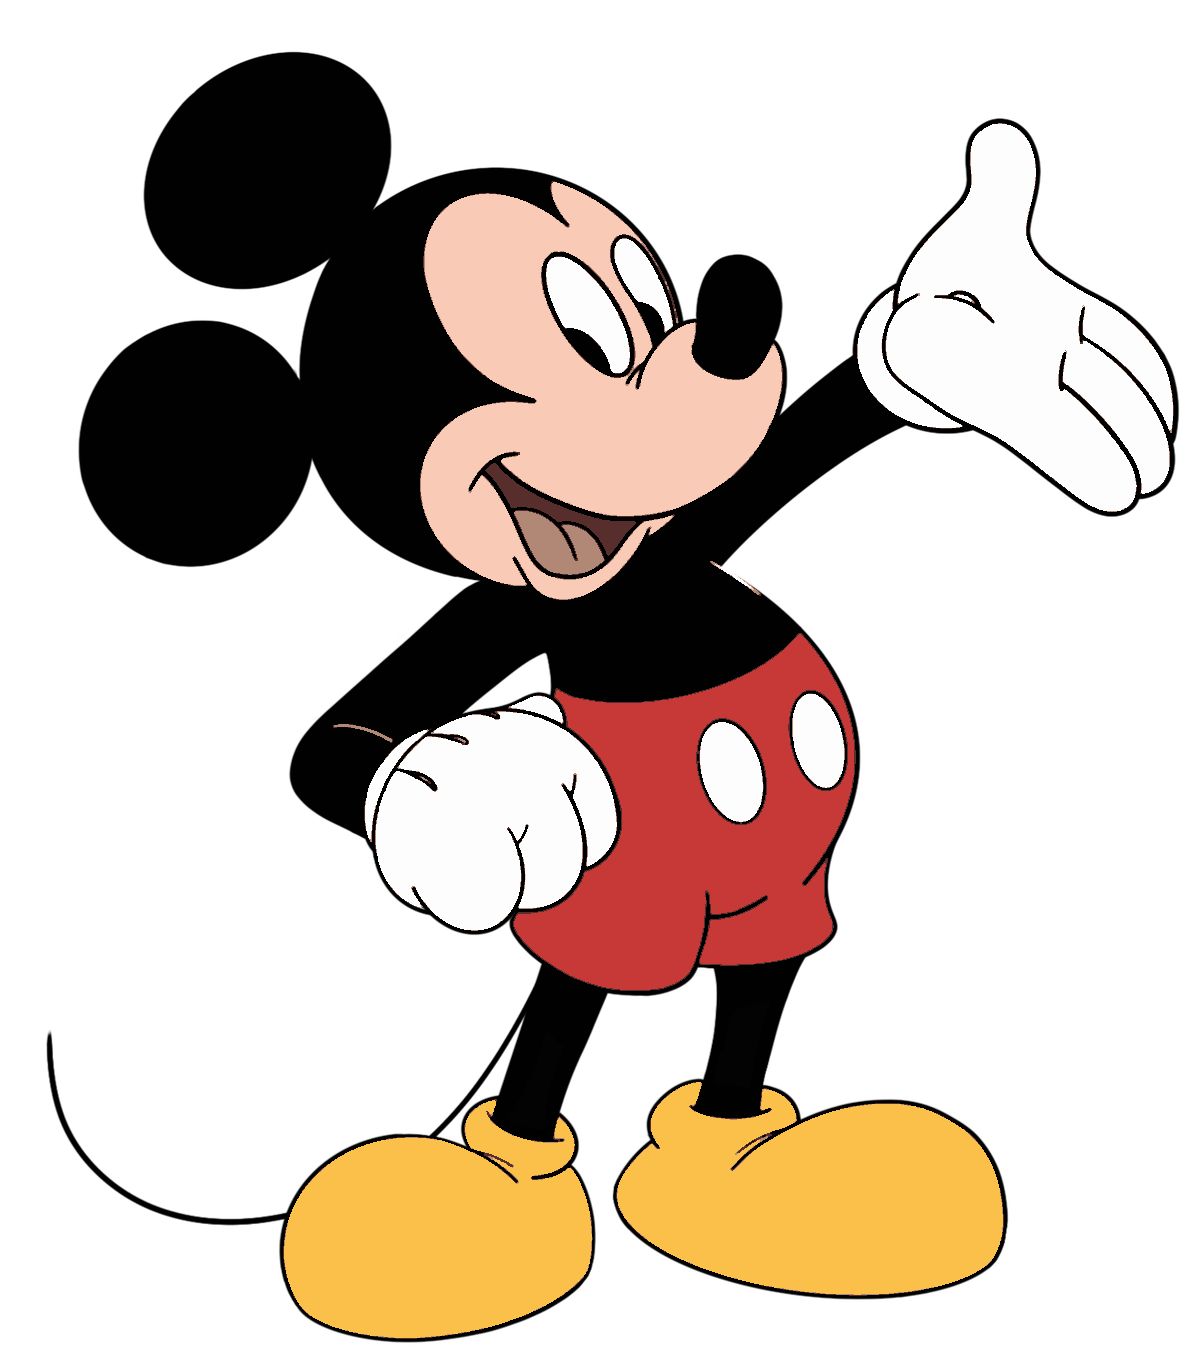

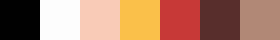

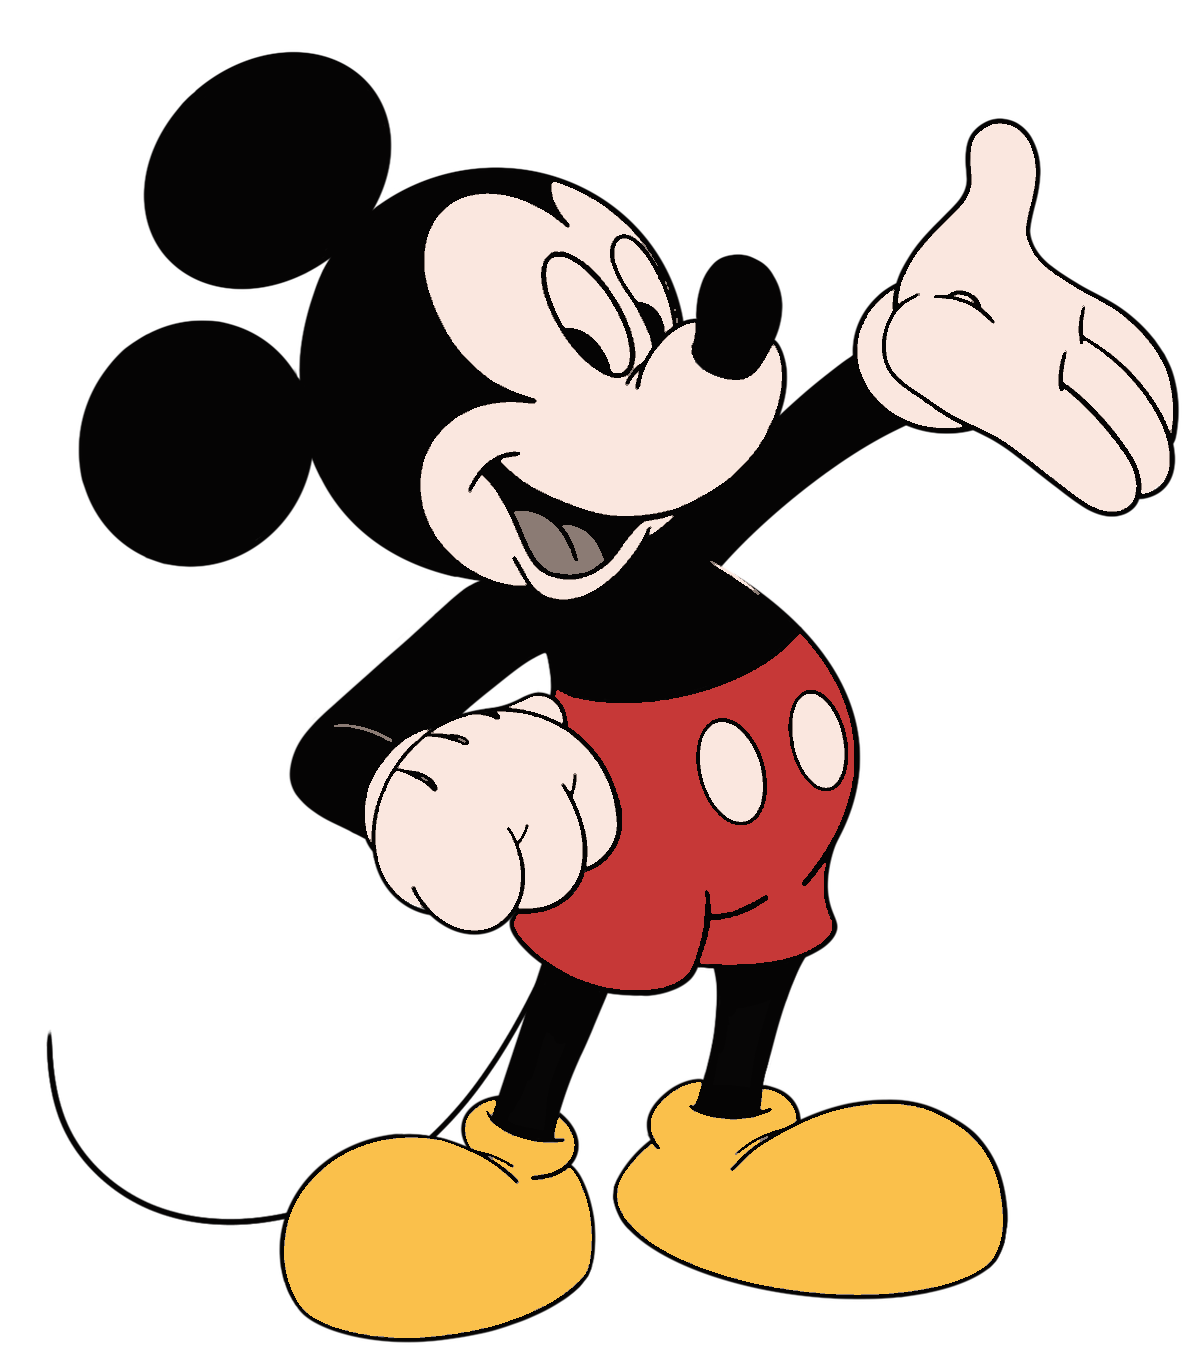

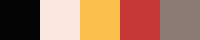

Debug: Applying median filter (size=3)...
Debug: Median filter applied successfully.
Debug: Step 1 (Median Filter) complete.
Debug: Step 2 (Area Threshold) complete.
Debug: Successfully assigned 666002 colors during posterization.
Debug: Step 3 (Posterize) complete.
Vectorization successful. SVG export enabled.


In [45]:
# --- Imports ---
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageOps
from skimage import color
from skimage.measure import label, regionprops
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.neighbors import NearestCentroid, NearestNeighbors
from collections import Counter
import io # For handling byte streams
import warnings
import ipywidgets as widgets
from google.colab import files
from IPython.display import display, HTML, Image as IPImage, clear_output
import glob # To find files
import cv2
import math
from skimage.morphology import binary_dilation # Needed for optimized hole finding
from skimage import measure
from collections import defaultdict # Important for grouping

# Add near other global variables like original_pil_image etc.
final_processed_image = None # Will store the result from step 3 (posterize/filter)
vectorization_elements = None # To store results for SVG export
vectorization_img_w = None
vectorization_img_h = None


# --- Helper function to display PIL Images in Jupyter ---
def display_pil_image(img: Image.Image, title: str = None, width=300):
    """Displays a PIL image in Jupyter with an optional title."""
    if title:
        display(HTML(f'<h4>{title}</h4>'))
    # Convert PIL image to bytes for IPImage display
    buffer = io.BytesIO()
    img_format = 'PNG' if img.mode == 'RGBA' else 'JPEG'
    try:
      img.save(buffer, format=img_format)
      buffer.seek(0)
      display(IPImage(data=buffer.getvalue(), width=width))
    except Exception as e:
      print(f"Error displaying image: {e}")


def display_rgb_palette(palette_rgb, title="Color Palette"):
    """ Displays a horizontal bar of the given RGB colors. """
    if not palette_rgb:
        print("No palette to display.")
        return
    valid_palette = [list(map(int, c)) for c in palette_rgb if isinstance(c, (list, tuple)) and len(c) == 3]
    if not valid_palette:
        print("Palette contains invalid color definitions.")
        return

    colors = np.array(valid_palette, dtype=np.uint8).reshape(1, -1, 3)
    palette_img = Image.fromarray(colors, 'RGB')
    scale = 40
    # Ensure width is at least 1 pixel
    width = max(1, len(valid_palette) * scale)
    height = scale # Keep height fixed
    palette_img = palette_img.resize((width, height), Image.NEAREST)

    if title:
         display(HTML(f'<h5>{title} ({len(valid_palette)} colors)</h5>'))
    # Convert palette image to bytes for display
    buffer = io.BytesIO()
    palette_img.save(buffer, format='PNG')
    buffer.seek(0)
    display(IPImage(data=buffer.getvalue()))


def quantize_with_alpha(img: Image.Image, num_colors: int, method=Image.Quantize.FASTOCTREE) -> (Image.Image | None, list):
    """ Quantize an RGB or RGBA image to `num_colors` with PIL and preserve alpha if present. """
    if not isinstance(img, Image.Image):
        print("Error: Input is not a valid PIL Image.")
        return None, []
    if not (2 <= num_colors <= 256):
        print("Error: num_colors must be between 2 and 256.")
        return None, []

    try:
        has_alpha = img.mode in ("RGBA", "LA", "P") and 'A' in img.getbands()

        if has_alpha:
            img_rgba = img.convert("RGBA") if img.mode != "RGBA" else img
            alpha = img_rgba.getchannel("A")
            rgb = img_rgba.convert("RGB")
            try:
                # Use a specific palette size request, dither off for flat colors
                pal_img = rgb.quantize(colors=num_colors, method=method, kmeans=num_colors, dither=Image.Dither.NONE)
            except ValueError:
                print(f"Warning: Quantize method {method} might not be optimal or failed. Trying MEDIANCUT.")
                pal_img = rgb.quantize(colors=num_colors, method=Image.Quantize.MEDIANCUT, dither=Image.Dither.NONE)

            pal_img_rgba = pal_img.convert("RGBA")
            pal_img_rgba.putalpha(alpha)
            # Extract palette carefully, handling cases where fewer colors are generated
            raw_palette = pal_img.getpalette()
            if raw_palette is None: return pal_img_rgba, [] # No palette generated
            actual_colors = len(raw_palette) // 3
            palette = np.array(raw_palette[:actual_colors * 3]).reshape(-1, 3).tolist()
            # Ensure palette length matches num_colors if possible, but don't exceed actual
            palette = palette[:min(num_colors, actual_colors)]
            return pal_img_rgba, palette
        else:
            rgb_img = img.convert("RGB")
            pal_img = rgb_img.quantize(colors=num_colors, method=method, kmeans=num_colors, dither=Image.Dither.NONE)
            raw_palette = pal_img.getpalette()
            if raw_palette is None: return pal_img.convert("RGB"), []
            actual_colors = len(raw_palette) // 3
            palette = np.array(raw_palette[:actual_colors * 3]).reshape(-1, 3).tolist()
            palette = palette[:min(num_colors, actual_colors)]
            return pal_img.convert("RGB"), palette
    except Exception as e:
        print(f"Error during PIL Quantization: {e}")
        import traceback
        traceback.print_exc()
        return None, []


def posterize_with_palette(img: Image.Image, palette_rgb: list) -> Image.Image | None:
    """ Remap image colors to the given RGB palette (preserves alpha). """
    # Input validation
    if not isinstance(img, Image.Image):
        print("Error: Input is not a valid PIL Image for posterization.")
        return None
    if not palette_rgb or not isinstance(palette_rgb, list):
         print("Error: Palette cannot be empty or invalid for posterization.")
         # Return a copy of the input image if palette is invalid
         return img.copy() if img else None
    # Check palette contents (basic check)
    if not all(isinstance(c, (list, tuple)) and len(c) == 3 for c in palette_rgb):
        print("Error: Palette contains invalid color entries.")
        return img.copy() if img else None


    try:
        is_rgba = img.mode == "RGBA"
        # Always work on a copy to be safe
        img_rgba = img.convert("RGBA") if not is_rgba else img.copy()

        arr = np.array(img_rgba)
        h, w = arr.shape[:2]
        alpha = arr[..., 3]
        rgb = arr[..., :3]
        mask = alpha > 0 # Boolean mask (H, W) where True means opaque

        # Get RGB values only for opaque pixels
        rgb_masked = rgb[mask] # Shape: (N_opaque, 3)
        if rgb_masked.size == 0:
            print("Debug: No opaque pixels found in image for posterization.")
            return img_rgba # Return original if fully transparent

        palette_arr = np.array(palette_rgb, dtype=np.uint8)
        # Check palette array validity after creation
        if palette_arr.size == 0 or palette_arr.ndim != 2 or palette_arr.shape[1] != 3:
             print(f"Warning: Invalid palette array shape {palette_arr.shape} derived for posterization. Skipping.")
             return img_rgba

        # Use NearestNeighbors to find the closest palette color for each opaque pixel
        try:
             nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(palette_arr)
             # distances, idx = nn.kneighbors(rgb_masked)
             _, idx = nn.kneighbors(rgb_masked) # idx shape: (N_opaque, 1)
        except Exception as knn_error:
            print(f"Error during NearestNeighbors fitting/prediction in posterize: {knn_error}")
            return img_rgba


        # Create the output array
        out_rgba = np.zeros_like(arr)
        out_rgba[..., 3] = alpha # Preserve original alpha

        # --- CORRECTED ASSIGNMENT ---
        try:
            # Flatten the indices array
            flattened_indices = idx.flatten() # Shape: (N_opaque,)

            # Ensure indices are within bounds (safety check)
            if np.any(flattened_indices >= len(palette_arr)) or np.any(flattened_indices < 0):
                print(f"Warning: Nearest neighbor indices out of bounds in posterize! Max idx: {np.max(flattened_indices)}, Palette size: {len(palette_arr)}. Clipping indices.")
                flattened_indices = np.clip(flattened_indices, 0, len(palette_arr) - 1)

            # Use the mask (H, W) to select *where* in out_rgba to assign colors.
            # Use the flattened_indices (N_opaque,) to select *which* colors from palette_arr.
            opaque_pixel_count = np.sum(mask)
            if opaque_pixel_count == len(flattened_indices):
                 out_rgba[mask, :3] = palette_arr[flattened_indices]
                 print(f"Debug: Successfully assigned {len(flattened_indices)} colors during posterization.")
            else:
                 # This case should ideally not happen if logic is correct
                 print(f"ERROR: Mismatch between opaque pixel count ({opaque_pixel_count}) and KNN result count ({len(flattened_indices)}) in posterize. Cannot assign colors reliably.")
                 # Return the image before posterization attempt in case of error
                 return img_rgba

        except IndexError as ie:
             # Catch potential index errors during assignment
             print(f"ERROR during final color assignment in posterize!")
             print(f"  mask True count: {opaque_pixel_count}")
             print(f"  palette_arr shape: {palette_arr.shape}")
             print(f"  idx shape: {idx.shape}")
             print(f"  flattened_indices shape: {flattened_indices.shape}")
             if flattened_indices.size > 0:
                  print(f"  Min/Max index: {np.min(flattened_indices)}, {np.max(flattened_indices)}")
             # Return the image before posterization attempt in case of error
             raise ie # Re-raise error after printing


        return Image.fromarray(out_rgba, 'RGBA')
        # --- END CORRECTION ---

    except Exception as e:
        print(f"Error during posterization function: {e}")
        import traceback
        traceback.print_exc()
        # Return a copy of the input image on failure
        return img.copy() if img else None



def quantize_cielab_with_alpha(img: Image.Image, num_colors: int) -> (Image.Image | None, list):
    """ KMeans quantization in CIELAB space, preserving alpha. """
    if not isinstance(img, Image.Image):
        print("Error: Input is not a valid PIL Image.")
        return None, []
    try:
        img_rgba = img.convert("RGBA") if img.mode != "RGBA" else img

        arr = np.array(img_rgba)
        h, w = arr.shape[:2]
        alpha = arr[..., 3]
        rgb = arr[..., :3]
        mask = alpha > 0

        rgb_masked = rgb[mask]
        if rgb_masked.size == 0: return img_rgba, []

        unique_colors_masked = np.unique(rgb_masked, axis=0)
        actual_num_colors = min(num_colors, len(unique_colors_masked))

        if actual_num_colors < 2: # Handle 0 or 1 unique opaque color
            if actual_num_colors == 1:
                centers_rgb = unique_colors_masked
                out_rgba = np.zeros_like(arr)
                out_rgba[..., 3] = alpha
                out_rgba[mask, :3] = centers_rgb[0]
                return Image.fromarray(out_rgba, 'RGBA'), centers_rgb.tolist()
            else:
                return img_rgba, [] # Should not happen if rgb_masked.size > 0

        # Convert masked RGB pixels to LAB for clustering
        with warnings.catch_warnings(): # Suppress potential precision warnings
            warnings.simplefilter("ignore", category=UserWarning)
            # Add a small epsilon to prevent division by zero with pure black
            rgb_float = rgb_masked / 255.0
            lab_masked = color.rgb2lab(np.clip(rgb_float, 1e-5, 1.0))


        try:
            km = KMeans(n_clusters=actual_num_colors, random_state=42, n_init='auto')
        except ValueError:
            km = KMeans(n_clusters=actual_num_colors, random_state=42, n_init=10)

        labels = km.fit_predict(lab_masked)
        centers_lab = km.cluster_centers_

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            centers_rgb = (color.lab2rgb(centers_lab.reshape(1, -1, 3))[0] * 255).clip(0, 255).astype(np.uint8)

        out_rgba = np.zeros_like(arr)
        out_rgba[..., 3] = alpha
        out_rgba[mask, :3] = centers_rgb[labels]

        return Image.fromarray(out_rgba, 'RGBA'), centers_rgb.tolist()

    except Exception as e:
        print(f"Error during CIELAB K-Means Quantization: {e}")
        import traceback
        traceback.print_exc()
        return None, []


def reduce_palette_kmeans(initial_palette_lab: np.ndarray | None, target_colors: int) -> np.ndarray | None:
    """ Reduce an LAB palette to `target_colors` via KMeans. """
    if initial_palette_lab is None or not isinstance(initial_palette_lab, np.ndarray) or initial_palette_lab.ndim != 2:
        return None
    if len(initial_palette_lab) <= target_colors:
        return initial_palette_lab

    actual_target = min(target_colors, len(initial_palette_lab))
    if actual_target < 1: return np.array([]) # Return empty if target is invalid

    try:
        kmeans = KMeans(n_clusters=actual_target, random_state=42, n_init='auto')
    except ValueError:
        kmeans = KMeans(n_clusters=actual_target, random_state=42, n_init=10)

    try:
        kmeans.fit(initial_palette_lab)
        return kmeans.cluster_centers_
    except Exception as e:
        print(f"Error during palette reduction KMeans: {e}")
        return None


def mean_shift_quantize(img: Image.Image,
                        downsample_factor: float = 0.25,
                        bandwidth_quantile: float = 0.2,
                        bandwidth_samples_pct: float = 20.0, # Now 0-100
                        desired_colors: int = 8) -> (Image.Image | None, list):
    """ Estimate palette via MeanShift, reduce via KMeans, reconstruct full-res. """
    if not isinstance(img, Image.Image):
        print("Error: Input is not a valid PIL Image.")
        return None, []
    try:
        orig_rgba = img.convert("RGBA") if img.mode != "RGBA" else img

        arr_rgba = np.array(orig_rgba)
        h, w = arr_rgba.shape[:2]
        alpha = arr_rgba[..., 3]
        rgb_full = arr_rgba[..., :3]
        mask_full = alpha > 0 # Boolean mask for opaque pixels (H, W)

        if not np.any(mask_full): return orig_rgba, [] # Return original if fully transparent

        # --- Downsampling (same as before) ---
        ds_w = max(1, int(w * downsample_factor))
        ds_h = max(1, int(h * downsample_factor))
        try:
            ds_img = orig_rgba.resize((ds_w, ds_h), resample=Image.Resampling.LANCZOS)
        except AttributeError: # Fallback for older PIL/Pillow
            ds_img = orig_rgba.resize((ds_w, ds_h), resample=Image.LANCZOS)
        ds_arr = np.array(ds_img)
        ds_alpha = ds_arr[..., 3]
        ds_rgb = ds_arr[..., :3]
        ds_mask = ds_alpha > 128 # Consider pixels > 50% opaque for clustering

        ds_rgb_masked = ds_rgb[ds_mask]
        palette_lab = None # Initialize palette_lab

        # --- MeanShift Clustering (same as before, with fallback) ---
        if ds_rgb_masked.size > 0:
            # (Keep the existing MeanShift logic here, including bandwidth estimation)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                ds_rgb_float = ds_rgb_masked / 255.0
                ds_lab_masked = color.rgb2lab(np.clip(ds_rgb_float, 1e-5, 1.0))

            n_total_pixels_ds = ds_lab_masked.shape[0]
            n_samples = max(100, min(n_total_pixels_ds, int(n_total_pixels_ds * (bandwidth_samples_pct / 100.0))))
            if n_samples < ds_lab_masked.shape[0] and n_samples > 0:
                sample_indices = np.random.choice(ds_lab_masked.shape[0], n_samples, replace=False)
                pixels_for_bw = ds_lab_masked[sample_indices]
            else:
                pixels_for_bw = ds_lab_masked

            bw = 1.0
            if pixels_for_bw.shape[0] >= 2:
                try:
                    bw = estimate_bandwidth(pixels_for_bw, quantile=bandwidth_quantile,
                                            n_samples=min(n_samples, pixels_for_bw.shape[0]), random_state=42)
                    bw = max(bw, 0.1) if bw is not None and bw > 0 else 1.0
                except Exception as e:
                    print(f"Warning: Bandwidth estimation failed ({e}), using default bw=1.0")
                    bw = 1.0
            else:
                print("Warning: Too few samples for bandwidth estimation, using default bw=1.0")

            ms = MeanShift(bandwidth=bw, cluster_all=False, n_jobs=-1, max_iter=100, bin_seeding=True)
            ms.fit(ds_lab_masked)
            if hasattr(ms, 'cluster_centers_') and len(ms.cluster_centers_) > 0:
                palette_lab = ms.cluster_centers_
            else:
                print("Warning: MeanShift found no cluster centers.")

        if palette_lab is None or len(palette_lab) == 0:
            # (Keep the existing K-Means fallback logic here)
            print("Warning: MeanShift failed/yielded no clusters. Falling back to K-Means...")
            rgb_full_masked = rgb_full[mask_full]
            if rgb_full_masked.size == 0: return orig_rgba, []
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                rgb_float = rgb_full_masked / 255.0
                lab_full_masked = color.rgb2lab(np.clip(rgb_float, 1e-5, 1.0))
            unique_lab_full = np.unique(lab_full_masked, axis=0)
            n_unique_full = len(unique_lab_full)
            if n_unique_full == 0: return orig_rgba, []
            actual_colors_km = min(desired_colors, n_unique_full)
            if actual_colors_km < 1: return orig_rgba, []
            try: km = KMeans(n_clusters=actual_colors_km, random_state=42, n_init='auto')
            except ValueError: km = KMeans(n_clusters=actual_colors_km, random_state=42, n_init=10)
            km.fit(lab_full_masked)
            palette_lab = km.cluster_centers_

        # --- Reduce palette via KMeans if necessary ---
        if palette_lab is not None and len(palette_lab) > desired_colors:
             palette_lab = reduce_palette_kmeans(palette_lab, desired_colors)

        if palette_lab is None or len(palette_lab) == 0:
            print("Error: Could not generate a final palette. Returning original image.")
            return orig_rgba, []

        # --- Convert final palette back to RGB ---
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            reduced_rgb = (color.lab2rgb(palette_lab.reshape(1, -1, 3))[0] * 255).clip(0, 255).astype(np.uint8)
            if len(reduced_rgb) == 0: # Handle empty palette case
                 print("Error: Final RGB palette is empty.")
                 return orig_rgba, []


        # --- Map original full-res non-transparent pixels to the reduced palette ---
        # Get LAB values only for the opaque pixels
        rgb_full_masked = rgb_full[mask_full]
        if rgb_full_masked.size == 0: # Should have been caught earlier, but double check
             return orig_rgba, [] # Nothing to map

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            rgb_float = rgb_full_masked / 255.0
            lab_full_masked = color.rgb2lab(np.clip(rgb_float, 1e-5, 1.0)) # Shape: (N_opaque, 3)

        # Find nearest neighbors in the final LAB palette
        nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(palette_lab)
        # distances, idx = nn.kneighbors(lab_full_masked)
        _, idx = nn.kneighbors(lab_full_masked) # idx shape: (N_opaque, 1)

        # --- Create Output Image & Assign Colors (Corrected) ---
        out_rgba = np.zeros_like(arr_rgba) # Shape (H, W, 4)
        out_rgba[..., 3] = alpha # Preserve original alpha

        try:
            # Flatten the indices array
            flattened_indices = idx.flatten() # Shape: (N_opaque,)

            # Ensure indices are within bounds (shouldn't be needed for KNN but safe)
            if np.any(flattened_indices >= len(reduced_rgb)) or np.any(flattened_indices < 0):
                print(f"Warning: Nearest neighbor indices out of bounds! Max idx: {np.max(flattened_indices)}, Palette size: {len(reduced_rgb)}. Clipping indices.")
                flattened_indices = np.clip(flattened_indices, 0, len(reduced_rgb) - 1)

            # Use the mask_full (H, W) to select *where* in out_rgba to assign colors.
            # Use the flattened_indices (N_opaque,) to select *which* colors from reduced_rgb.
            # The number of True values in mask_full must equal the length of flattened_indices.
            if np.sum(mask_full) == len(flattened_indices):
                 out_rgba[mask_full, :3] = reduced_rgb[flattened_indices]
            else:
                 # This indicates a potential logic error earlier
                 print(f"ERROR: Mismatch between opaque pixel count ({np.sum(mask_full)}) and KNN result count ({len(flattened_indices)}). Cannot assign colors.")
                 # Optionally return original or partially processed image
                 return orig_rgba, []


        except IndexError as ie:
             print(f"ERROR during final color assignment in MeanShift!")
             print(f"  mask_full True count: {np.sum(mask_full)}")
             print(f"  reduced_rgb shape: {reduced_rgb.shape}")
             print(f"  idx shape: {idx.shape}")
             print(f"  flattened_indices shape: {flattened_indices.shape}")
             if flattened_indices.size > 0:
                  print(f"  Min/Max index: {np.min(flattened_indices)}, {np.max(flattened_indices)}")
             raise ie

        # --- Return Final Image and Palette ---
        return Image.fromarray(out_rgba, 'RGBA'), reduced_rgb.tolist()

    # --- Overall Error Handling ---
    except Exception as e:
        print(f"Error during MeanShift Quantization: {e}")
        import traceback
        traceback.print_exc()
        # Attempt to return original image gracefully if possible
        try:
            if 'orig_rgba' in locals() and isinstance(orig_rgba, Image.Image):
                return orig_rgba, []
            elif isinstance(img, Image.Image):
                return img.copy(), []
            else:
                return None, []
        except:
             return None, [] # Final fallback


def apply_median_filter_preserve_alpha(image: Image.Image, size: int) -> Image.Image | None:
    """ Applies median filter to RGB channels, preserves original alpha. Does NOT remap. """
    if not isinstance(image, Image.Image):
        print("Error: Input is not a valid PIL Image for median filter.")
        return None
    if size <= 1: # No filtering needed
        print("Debug: Median filter size <= 1, skipping filter.")
        return image.copy() # Return a copy
    if not isinstance(size, int) or size % 2 == 0:
        print(f"Warning: Median filter size ({size}) must be an odd integer > 1. Skipping filter.")
        return image.copy() # Return a copy

    try:
        print(f"Debug: Applying median filter (size={size})...")
        # Ensure RGBA and work on a copy
        img_to_process = image.convert('RGBA') if image.mode != 'RGBA' else image.copy()

        # Separate RGB and Alpha
        rgb_channels = img_to_process.split()[:3]
        alpha_channel = img_to_process.split()[3] # Get alpha channel

        # Apply median filter to merged RGB image
        rgb_img = Image.merge('RGB', rgb_channels)
        filtered_rgb_img = rgb_img.filter(ImageFilter.MedianFilter(size=size))

        # Merge filtered RGB with original alpha
        filtered_rgba = Image.merge('RGBA', (*filtered_rgb_img.split(), alpha_channel))
        print("Debug: Median filter applied successfully.")
        return filtered_rgba

    except Exception as e:
        print(f"Error during Median Filtering (preserve alpha): {e}")
        import traceback
        traceback.print_exc()
        return None


def remove_minority_pixels(image: Image.Image, area_threshold: int) -> Image.Image | None:
    """ Removes small connected components, replacing with neighbor color (preserves alpha). """
    if not isinstance(image, Image.Image):
        print("Error: Input is not a valid PIL Image.")
        return None
    if area_threshold <= 0: return image # Skip if threshold is non-positive

    try:
        img_to_process = image.convert('RGBA') if image.mode != 'RGBA' else image.copy()

        arr = np.array(img_to_process)
        h, w = arr.shape[:2]
        alpha = arr[..., 3]
        rgb = arr[..., :3]
        cleaned_rgb = rgb.copy()
        opaque_mask = alpha > 0

        if not np.any(opaque_mask): return img_to_process # Return original if fully transparent

        # --- Optimization: Integer map creation ---
        # Create tuples of unique opaque colors and map them to integers
        unique_colors_rgb = np.unique(rgb[opaque_mask].reshape(-1, 3), axis=0)
        color_to_int = {tuple(c): i + 1 for i, c in enumerate(unique_colors_rgb)}
        # Create an integer map efficiently
        int_map = np.zeros((h, w), dtype=np.int32)
        for color_val, int_val in color_to_int.items():
             mask_color = np.all(rgb == color_val, axis=2) & opaque_mask
             int_map[mask_color] = int_val
        # --- End Optimization ---


        # Label connected components on the integer map
        # connectivity=1 (4-way) might be slightly faster if sufficient
        lbl = label(int_map, connectivity=2, background=0)
        regs = regionprops(lbl) # No intensity image needed

        pixels_replaced_count = 0
        neighbor_offsets = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

        for reg in regs:
            if reg.area < area_threshold:
                region_label_val = reg.label # The integer label of this region
                coords = reg.coords # Nx2 array of (row, col)

                # --- Optimization: Find neighbors more efficiently ---
                # 1. Get bounding box with 1px border
                min_r, min_c, max_r, max_c = reg.bbox
                bb_r_min, bb_r_max = max(0, min_r - 1), min(h, max_r + 1)
                bb_c_min, bb_c_max = max(0, min_c - 1), min(w, max_c + 1)

                # 2. Extract label and RGB values in the bordered bounding box
                sub_lbl = lbl[bb_r_min:bb_r_max, bb_c_min:bb_c_max]
                sub_rgb = rgb[bb_r_min:bb_r_max, bb_c_min:bb_c_max]
                sub_alpha = alpha[bb_r_min:bb_r_max, bb_c_min:bb_c_max]

                # 3. Create a mask for the region itself within the sub-array
                region_mask_sub = (sub_lbl == region_label_val)

                # 4. Dilate the region mask to find potential neighbors
                from skimage.morphology import binary_dilation
                neighbor_mask_sub = binary_dilation(region_mask_sub)

                # 5. Identify true neighbors: dilated area MINUS region itself, AND opaque, AND not part of the same region
                true_neighbors_mask = (neighbor_mask_sub & ~region_mask_sub & (sub_alpha > 0) & (sub_lbl != region_label_val) & (sub_lbl != 0))

                # 6. Get the colors of the true neighbors
                neighbor_colors_tuples = [tuple(c) for c in sub_rgb[true_neighbors_mask]]
                # --- End Optimization ---


                if neighbor_colors_tuples:
                    fill_color = Counter(neighbor_colors_tuples).most_common(1)[0][0]
                    fill_color_arr = np.array(fill_color, dtype=np.uint8)
                    # Apply fill color to the original coordinates
                    rows, cols = coords.T
                    cleaned_rgb[rows, cols] = fill_color_arr
                    pixels_replaced_count += reg.area
                # else: No opaque neighbors found, leave the region as is

        #if pixels_replaced_count > 0:
        #    print(f"Removed/replaced {pixels_replaced_count} pixels from small regions.")
        #else:
        #    print("No small regions found or replaced meeting criteria.")

        cleaned_rgba = np.dstack([cleaned_rgb, alpha])
        return Image.fromarray(cleaned_rgba, 'RGBA')

    except Exception as e:
        print(f"Error during Minority Pixel Removal: {e}")
        import traceback
        traceback.print_exc()
        return None


# --- Global variables to store state ---
original_pil_image = None
selected_file_path = None # Store the path of the selected file
generated_results = {
    'pil': {'quantized': None, 'palette': []},
    'kmeans': {'quantized': None, 'palette': []},
    'meanshift': {'quantized': None, 'palette': []},
}

# --- Constants ---
IMAGE_DIR = '/content/uploaded_images/' # Store uploaded images in a sub-directory

# --- UI Widget Definitions ---

# 1. File Upload Section (New Approach)
upload_instruction = widgets.HTML("<b>Step 1:</b> Use the button below to upload images into the Colab environment.")
upload_trigger_button = widgets.Button(description="Upload Image(s) to Colab", button_style='primary')
upload_output = widgets.Output() # To show upload status/errors

# 2. File Selection Section
select_instruction = widgets.HTML("<b>Step 2:</b> Refresh the list and select an uploaded image.")
refresh_button = widgets.Button(description="Refresh File List", button_style='info')
file_dropdown = widgets.Dropdown(
    options=[' '], # Start with empty or placeholder
    description='Select Image:',
    style={'description_width': 'initial'},
    disabled=True # Disabled until files are found
)
original_img_out = widgets.Output()

# 3. Quantization Parameters (Same as before)
num_colors_slider = widgets.IntSlider(
    value=8, min=2, max=32, step=1, description='# Colors:', continuous_update=False, disabled=True
)
bw_quantile_slider = widgets.FloatSlider(
    value=0.2, min=0.05, max=0.95, step=0.05, description='BW Quantile:', continuous_update=False, readout_format='.2f', disabled=True
)
generate_button = widgets.Button(description="Generate Palettes", button_style='info', disabled=True)
quant_params_box = widgets.VBox([
    num_colors_slider,
    bw_quantile_slider,
])
quant_out = widgets.Output() # Output area for quantized images/palettes

# 4. Palette Selection & Post-processing Parameters (Same as before)
palette_selector = widgets.RadioButtons(
    options=['PIL', 'K-Means', 'MeanShift'],
    description='Choose Palette:',
    disabled=True
)
median_slider = widgets.IntSlider(
    value=3, min=1, max=11, step=2, description='Median Size:', continuous_update=False, disabled=True
)
area_slider = widgets.IntSlider(
    value=5, min=0, max=100, step=1, description='Area Thresh:', continuous_update=False, disabled=True
)
process_button = widgets.Button(description="Process Final Image", button_style='success', disabled=True)
post_process_params_box = widgets.VBox([median_slider, area_slider])
final_image_out = widgets.Output() # Output area for the final image

# --- Callback Functions ---

def trigger_colab_upload(b):
    """Initiates Colab file upload and updates dropdown afterward."""
    with upload_output:
        clear_output(wait=True)
        print(f"Attempting to upload files to: {IMAGE_DIR}")
        # Ensure the target directory exists
        os.makedirs(IMAGE_DIR, exist_ok=True)
        try:
            # Change CWD temporarily for upload if needed, or use upload_to
            # For simplicity, let's rely on user selecting the directory or use default /content
            # uploaded = files.upload() # This uploads to /content by default

            # Better: Use sidebar or be explicit about upload location in instructions
            print("Please use the Colab file browser (folder icon on the left sidebar)")
            print(f"to upload your image files into the '{IMAGE_DIR}' directory.")
            print("Then click 'Refresh File List'.")

            # Alternative: Directly trigger upload (less control over location for user)
            # print("Select files to upload...")
            # %cd {IMAGE_DIR}
            # uploaded = files.upload()
            # %cd /content
            # if uploaded:
            #    print(f"Uploaded {len(uploaded)} file(s).")
            #    update_dropdown_options() # Update dropdown after upload
            # else:
            #    print("Upload cancelled or failed.")

        except Exception as e:
            print(f"An error occurred during upload trigger: {e}")

def update_dropdown_options(b=None):
    """Finds image files in IMAGE_DIR and updates the dropdown options."""
    global file_dropdown # Allow modification of the dropdown widget
    try:
        # Look for common image file extensions in the specified directory
        search_path = os.path.join(IMAGE_DIR, '*.*') # Simplistic for now
        # More specific:
        allowed_extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp', '*.gif', '*.webp']
        found_files = []
        for ext in allowed_extensions:
            found_files.extend(glob.glob(os.path.join(IMAGE_DIR, ext)))
            found_files.extend(glob.glob(os.path.join(IMAGE_DIR, ext.upper()))) # Case-insensitive

        # Remove duplicates if any and sort
        found_files = sorted(list(set(found_files)))

        if not found_files:
            options = [("No image files found in " + IMAGE_DIR, ' ')]
            file_dropdown.options = options
            file_dropdown.value = ' '
            file_dropdown.disabled = True
             # Also clear downstream outputs and disable buttons
            with original_img_out: clear_output()
            with quant_out: clear_output()
            with final_image_out: clear_output()
            num_colors_slider.disabled = True
            bw_quantile_slider.disabled = True
            generate_button.disabled = True
            palette_selector.disabled = True
            median_slider.disabled = True
            area_slider.disabled = True
            process_button.disabled = True

        else:
             # Create (Display Name, Value) pairs for dropdown
             # Display only filename, value is full path
             options = [(os.path.basename(f), f) for f in found_files]
             options.insert(0, ("--Select a file--", ' ')) # Add placeholder
             file_dropdown.options = options
             # file_dropdown.value = ' ' # Keep placeholder selected initially
             file_dropdown.disabled = False

    except Exception as e:
        print(f"Error updating file list: {e}")
        file_dropdown.options = [("Error listing files", ' ')]
        file_dropdown.value = ' '
        file_dropdown.disabled = True


def on_dropdown_change(change):
    """Loads the selected image, displays it, enables generation."""
    global original_pil_image, selected_file_path, generated_results
    selected_file_path = change['new'] # The 'value' is the full path

    # Reset downstream state whenever selection changes
    original_pil_image = None
    generated_results = { 'pil': {'quantized': None, 'palette': []}, 'kmeans': {'quantized': None, 'palette': []}, 'meanshift': {'quantized': None, 'palette': []} }
    with quant_out: clear_output(wait=True)
    with final_image_out: clear_output(wait=True)
    num_colors_slider.disabled = True
    bw_quantile_slider.disabled = True
    generate_button.disabled = True
    palette_selector.disabled = True
    median_slider.disabled = True
    area_slider.disabled = True
    process_button.disabled = True


    if selected_file_path and selected_file_path != ' ': # Check if a valid file path is selected
        try:
            original_pil_image = Image.open(selected_file_path)
            # Ensure RGBA for consistency downstream
            if original_pil_image.mode != 'RGBA':
                 original_pil_image = original_pil_image.convert('RGBA')

            with original_img_out:
                clear_output(wait=True)
                print(f"Selected '{os.path.basename(selected_file_path)}' ({original_pil_image.width}x{original_pil_image.height})")
                display_pil_image(original_pil_image, "Selected Image", width=400)

            # Enable next steps
            num_colors_slider.disabled = False
            bw_quantile_slider.disabled = False
            generate_button.disabled = False

        except Exception as e:
            with original_img_out:
                clear_output(wait=True)
                print(f"Error loading selected image '{os.path.basename(selected_file_path)}': {e}")
            original_pil_image = None
            # Keep buttons disabled
    else:
        # Placeholder selected or invalid path
        with original_img_out:
            clear_output(wait=True)
            print("Please select an image file from the list.")
        original_pil_image = None
        # Keep buttons disabled


def on_generate_clicked(b):
    """ Runs quantization methods based on current parameters and selected image. """
    global generated_results
    if not original_pil_image or not selected_file_path:
        with quant_out:
            clear_output(wait=True)
            print("Please select a valid image file first.")
        return

    # Get parameters
    n_colors = num_colors_slider.value
    bw_q = bw_quantile_slider.value
    ds_factor = 0.2 # Keep fixed for now
    bw_samples_pct = 20.0 # Keep fixed for now

    # Disable buttons during processing
    generate_button.disabled = True
    palette_selector.disabled = True
    median_slider.disabled = True
    area_slider.disabled = True
    process_button.disabled = True


    with quant_out:
        clear_output(wait=True)
        print(f"Generating palettes for '{os.path.basename(selected_file_path)}'...")
        print(f"Params: #Colors={n_colors}, BW Quantile={bw_q:.2f}")


    # --- Run Quantization Methods ---
    # Use original_pil_image.copy() to avoid modifying the loaded image
    img_copy = original_pil_image.copy()
    results_temp = {} # Store results locally first

    try:
        display(HTML("<hr><h3>Method 1: PIL Quantization (Fast Octree)</h3>"))
        pil_q, pil_p = quantize_with_alpha(img_copy, n_colors, Image.Quantize.FASTOCTREE)
        results_temp['pil'] = {'quantized': pil_q, 'palette': pil_p or []} # Ensure palette is list
        if pil_q: display_pil_image(pil_q, f"PIL Quantized ({len(pil_p or [])} colors)")
        if pil_p: display_rgb_palette(pil_p, 'PIL Palette')
    except Exception as e:
        print(f"Error during PIL Quantization: {e}")
        results_temp['pil'] = {'quantized': None, 'palette': []}

    try:
        display(HTML("<hr><h3>Method 2: CIELAB K-Means Quantization</h3>"))
        kmeans_q, kmeans_p = quantize_cielab_with_alpha(img_copy, n_colors)
        results_temp['kmeans'] = {'quantized': kmeans_q, 'palette': kmeans_p or []}
        if kmeans_q: display_pil_image(kmeans_q, f"CIELAB K-Means Quantized ({len(kmeans_p or [])} colors)")
        if kmeans_p: display_rgb_palette(kmeans_p, 'CIELAB K-Means Palette')
    except Exception as e:
        print(f"Error during CIELAB K-Means Quantization: {e}")
        results_temp['kmeans'] = {'quantized': None, 'palette': []}

    try:
        display(HTML("<hr><h3>Method 3: MeanShift Quantization</h3>"))
        ms_q, ms_p = mean_shift_quantize(img_copy,
                                        downsample_factor=ds_factor,
                                        bandwidth_quantile=bw_q,
                                        bandwidth_samples_pct=bw_samples_pct,
                                        desired_colors=n_colors)
        results_temp['meanshift'] = {'quantized': ms_q, 'palette': ms_p or []}
        if ms_q: display_pil_image(ms_q, f"MeanShift Quantized ({len(ms_p or [])} colors)")
        if ms_p: display_rgb_palette(ms_p, 'MeanShift Palette')
    except Exception as e:
        print(f"Error during MeanShift Quantization: {e}")
        results_temp['meanshift'] = {'quantized': None, 'palette': []}


    # Update global results
    generated_results = results_temp

    # Re-enable generate button and enable next steps if palettes exist
    generate_button.disabled = False
    if any(p['palette'] for p in generated_results.values()):
        palette_selector.disabled = False
        median_slider.disabled = False
        area_slider.disabled = False
        process_button.disabled = False
        with quant_out:
             display(HTML("<hr><i>Palette generation complete. Choose palette & post-processing params.</i>"))
    else:
        with quant_out:
            display(HTML("<hr><b>Warning: No valid palettes were generated. Adjust parameters or check image.</b>"))
        # Keep subsequent steps disabled


def on_process_clicked(b):
    """ Applies Median Filter -> Area Removal -> Posterization. """
    global original_pil_image, selected_file_path, generated_results # Ensure globals are accessible

    if not original_pil_image or not selected_file_path:
        with final_image_out:
            clear_output(wait=True)
            print("Please select a valid image file first.")
        return

    selected_method_key = palette_selector.value.lower().replace(' ', '').replace('-', '')

    # Check if results for the selected method exist and have a palette
    if (selected_method_key not in generated_results or
        not generated_results[selected_method_key] or
        'palette' not in generated_results[selected_method_key] or # Check key exists
        not generated_results[selected_method_key]['palette']): # Check palette is not empty
         with final_image_out:
            clear_output(wait=True)
            print(f"No valid palette generated or selected for the '{palette_selector.value}' method. Please generate palettes first.")
         return

    chosen_palette = generated_results[selected_method_key]['palette']
    median_size = median_slider.value
    area_thresh = area_slider.value

    # Disable button during processing
    process_button.disabled = True

    with final_image_out:
        clear_output(wait=True)
        print(f"Processing '{os.path.basename(selected_file_path)}' using '{palette_selector.value}' palette...")
        # Updated order description
        print(f"Step 1: Applying Median Filter (Size={median_size})...")
        print(f"Step 2: Applying Area Threshold ({area_thresh}px)...")
        print(f"Step 3: Posterizing to chosen palette...")

    try:
        # Make a fresh copy for processing chain
        img_to_process = original_pil_image.copy()

        # 1. Apply Median Filter (Preserving Alpha, No Remapping)
        median_filtered_img = apply_median_filter_preserve_alpha(img_to_process, median_size)
        if not median_filtered_img:
            # Error message already printed in the function
            raise ValueError("Median filtering step failed.")
        print("Debug: Step 1 (Median Filter) complete.")

        # 2. Apply Minority Pixel Removal to the median filtered image
        cleaned_image = remove_minority_pixels(median_filtered_img, area_thresh)
        if not cleaned_image:
            # Error message already printed in the function
            raise ValueError("Minority pixel removal step failed.")
        print("Debug: Step 2 (Area Threshold) complete.")

        # 3. Posterize the result of area removal with the chosen palette
        final_posterized_img = posterize_with_palette(cleaned_image, chosen_palette)
        if not final_posterized_img:
            # Error message already printed in the function
            raise ValueError("Posterization step failed.")
        print("Debug: Step 3 (Posterize) complete.")

        # 4. Display final result
        with final_image_out: # Append to existing messages
             print("\nProcessing complete.")
             # Updated title to reflect the process
             display_pil_image(final_posterized_img, f"Final Image (Median: {median_size}, Area: {area_thresh}, Palette: {palette_selector.value})", width=500)
             global final_processed_image # Declare modification of global
             final_processed_image = final_posterized_img

             # Enable vectorization step now that we have an image
             vectorize_button.disabled = False
             min_size_slider.disabled = False
             border_size_slider.disabled = False
             epsilon_slider.disabled = False
             # Keep SVG button disabled until vectorization is done
             export_svg_button.disabled = True

    except Exception as e:
        # Catch errors from the processing steps
        with final_image_out: # Append error to messages
            print(f"\n--- ERROR DURING FINAL PROCESSING ---")
            # Error message might have been printed already by the failing function
            print(f"Failed Step Error: {type(e).__name__}: {e}")
            # Print traceback if not already done, or just indicate failure
            # import traceback # Already imported in helper functions now
            # traceback.print_exc()
            print(f"--- END ERROR ---")

    # Re-enable button regardless of success or failure
    process_button.disabled = False


# --- Main Execution ---

# Ensure upload directory exists
os.makedirs(IMAGE_DIR, exist_ok=True)

# --- Wire up callbacks ---
upload_trigger_button.on_click(trigger_colab_upload) # Button to explain upload
refresh_button.on_click(update_dropdown_options)
file_dropdown.observe(on_dropdown_change, names='value')
generate_button.on_click(on_generate_clicked)
process_button.on_click(on_process_clicked)


# --- Layout and Display UI ---
display(HTML("<h2>Color Quantization Workflow</h2>"))

# Section 1: Upload & Select
display(HTML("<hr><h3>1. Upload & Select Image</h3>"))
upload_box = widgets.VBox([
    upload_instruction,
    # upload_trigger_button, # Using sidebar upload is often more robust
    upload_output,
    widgets.HTML(f"Upload files to the <code>{IMAGE_DIR}</code> directory using the Colab sidebar (folder icon <i class='fa fa-folder-open'></i>) or other methods."),
    refresh_button,
    file_dropdown
])
display(upload_box)
display(original_img_out) # Area for selected image display

# Section 2: Generate Palettes
display(HTML("<hr><h3>2. Generate Palettes</h3>"))
display(widgets.HTML("Set quantization parameters:"))
display(quant_params_box)
display(generate_button)
display(quant_out) # Area for quantized images + palettes

# Section 3: Select & Post-Process
display(HTML("<hr><h3>3. Select Palette & Post-Process</h3>"))
display(palette_selector)
display(widgets.HTML("Set post-processing parameters:"))
display(post_process_params_box)
display(process_button)
display(final_image_out) # Area for the final result

# --- Initial Population ---
# Populate dropdown on initial run
update_dropdown_options()


# @title Step 4: Vectorization Pipeline & SVG Export (Run After Image Processing)

# --- Vectorization Helper Functions ---

def apply_element_with_masking(target_canvas, element, labeled_image, elements_list, h, w, color_override=None):
    """ Applies an element's color to a target canvas using masking to handle empty holes. (Modified slightly for robustness)"""
    if not isinstance(element, dict) or not all(k in element for k in ['label_id', 'children', 'contour', 'depth', 'centroid']):
        print(f"Warning: Element {element.get('id', 'N/A')} missing required keys. Skipping draw.")
        return
    if element['depth'] is None or element['depth'] == -1:
        return # Skip invalid depth elements

    element_color = color_override if color_override is not None else element.get('colour')
    if element_color is None:
        print(f"Warning: Element {element.get('id', 'N/A')} missing color. Skipping draw.")
        return
    label_id = element['label_id']

    element_mask = np.zeros((h, w), dtype=np.uint8)
    comp_mask_holes = (labeled_image == label_id).astype(np.uint8) * 255
    if cv2.countNonZero(comp_mask_holes) == 0: return

    contours_including_holes, hierarchy_holes = cv2.findContours(
        comp_mask_holes, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
    )

    outer_contour_index_in_list = -1
    empty_hole_contours = []

    if hierarchy_holes is not None and len(contours_including_holes) > 0:
        hierarchy_holes = hierarchy_holes[0]
        possible_outer_indices = [idx for idx, hier_info in enumerate(hierarchy_holes) if hier_info[3] == -1]

        if not possible_outer_indices:
            cv2.drawContours(element_mask, [element['contour']], -1, 255, cv2.FILLED) # Fallback
        else:
            outer_contour_index_in_list = max(possible_outer_indices, key=lambda idx: cv2.contourArea(contours_including_holes[idx]))
            cv2.drawContours(element_mask, [contours_including_holes[outer_contour_index_in_list]], -1, 255, cv2.FILLED)

            # Find empty holes
            for hole_index, hier_info in enumerate(hierarchy_holes):
                if hier_info[3] == outer_contour_index_in_list:
                    hole_contour = contours_including_holes[hole_index]
                    if cv2.contourArea(hole_contour) < 1: continue
                    is_empty_hole = True
                    current_depth = element['depth']
                    # Check centroids of DEEPER elements
                    for other in elements_list:
                        if other.get('depth', -1) > current_depth:
                             if cv2.pointPolygonTest(hole_contour, tuple(other['centroid']), False) >= 0:
                                is_empty_hole = False; break
                    if is_empty_hole: empty_hole_contours.append(hole_contour)

            if empty_hole_contours: cv2.drawContours(element_mask, empty_hole_contours, -1, 0, cv2.FILLED)
    else:
        cv2.drawContours(element_mask, [element['contour']], -1, 255, cv2.FILLED) # Fallback

    # Apply Color using the Final Mask
    if target_canvas.ndim == 3 and target_canvas.shape[2] >= 3: # Allow BGRA or BGR
        target_canvas[element_mask == 255, :3] = element_color # Apply BGR part
        if target_canvas.shape[2] == 4: # If canvas is BGRA, set alpha
             target_canvas[element_mask == 255, 3] = 255
    else:
        print(f"Error: target_canvas invalid shape {target_canvas.shape}")


def make_checkerboard(H, W, block=20, a=(230,230,230), b=(200,200,200)):
    """Creates a checkerboard pattern image (BGR)."""
    block = max(1, block); yy, xx = np.indices((H, W)); patt = ((yy // block) + (xx // block)) % 2
    board = np.empty((H, W, 3), np.uint8); board[patt == 0] = a; board[patt == 1] = b; return board

# --- SVG Helper Functions ---
def contour_to_svg_path(cnt):
    pts = cnt.reshape(-1, 2)
    if len(pts) == 0: return ""
    d = [f"M {pts[0][0]} {pts[0][1]}"] + [f"L {x} {y}" for x, y in pts[1:]] + ["Z"]
    return " ".join(d)

def bgr_to_hex(bgr):
    # Ensure integers and clamp values
    b, g, r = [max(0, min(255, int(c))) for c in bgr]
    return f"#{r:02x}{g:02x}{b:02x}"


# --- Main Vectorization Pipeline Function ---
# Replace the ENTIRE run_vectorization_pipeline function with this version:

def run_vectorization_pipeline(input_pil_image, min_size_percent, border_strip_size, contour_epsilon):
    """Runs the vectorization steps and returns True on success, False on failure."""
    global vectorization_elements, vectorization_img_w, vectorization_img_h # Allow update

    # --- Reset global results at the start ---
    vectorization_elements = None
    vectorization_img_w = None
    vectorization_img_h = None
    elements = [] # Local list for this run

    print("--- Starting Vectorization Pipeline ---")
    # --- Input Validation and OpenCV Conversion ---
    if not isinstance(input_pil_image, Image.Image):
        print("Error: Invalid input image (must be PIL Image).")
        return False # Indicate failure
    try:
        if input_pil_image.mode != 'RGBA':
             img_rgba = input_pil_image.convert('RGBA')
        else:
             img_rgba = input_pil_image
        img_np_rgba = np.array(img_rgba)
        img_bgra = cv2.cvtColor(img_np_rgba, cv2.COLOR_RGBA2BGRA)
    except Exception as e:
        print(f"Error converting input PIL image to OpenCV format: {e}")
        return False
    print(f"Input image converted to OpenCV BGRA format ({img_bgra.shape}).")

    # --- Parameters & Initial Setup ---
    MIN_SIZE_PERCENT = min_size_percent
    BORDER_STRIP_SIZE = border_strip_size
    CONTOUR_SIMPLIFICATION_EPSILON = contour_epsilon
    CONNECTIVITY = 2 # 8-way
    img = img_bgra
    h, w = img.shape[:2]
    print(f"Image dimensions: {w}x{h}")

    # --- Extract BGR, Alpha, Foreground Mask ---
    if img.shape[2] == 4:
        bgr = img[:, :, :3]
        alpha = img[:, :, 3]
        mask_fg = (alpha > 128)
    else: # Fallback
        print("Warning: Input image unexpectedly not BGRA. Treating as BGR.")
        bgr = img
        alpha = np.full((h, w), 255, dtype=np.uint8)
        mask_fg = np.ones((h, w), dtype=bool)

    num_fg_pixels = np.sum(mask_fg)
    if num_fg_pixels == 0:
        print("Error: No foreground pixels found. Cannot proceed.")
        return False
    print(f"Found {num_fg_pixels} foreground pixels.")

    # --- Compute Minimum Component Size ---
    MIN_SIZE = math.ceil((MIN_SIZE_PERCENT / 100.0) * num_fg_pixels)
    print(f"Minimum size for merging components: {MIN_SIZE} pixels ({MIN_SIZE_PERCENT}% of foreground area)")

    # --- Build Palette ---
    fg_colors_bgr = bgr[mask_fg]
    if fg_colors_bgr.size == 0:
        print("Error: Cannot build BGR palette from foreground.")
        return False
    unique_colors_array = np.unique(fg_colors_bgr, axis=0)
    palette = sorted([tuple(c) for c in unique_colors_array])
    print(f"Found {len(palette)} unique foreground BGR colors.")

    # --- Prepare Border Kernel ---
    border_kernel = None
    if BORDER_STRIP_SIZE >= 1:
         kernel_size = (max(1, BORDER_STRIP_SIZE), max(1, BORDER_STRIP_SIZE))
         border_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
         print(f" - Using border strip kernel size: {kernel_size}")

    # --- Step 1: Intermediate Image with Simplified Contours ---
    print("\nStep 1: Creating intermediate image with simplified contours...")
    # (Logic remains the same - assumes no problematic semicolons here)
    if BORDER_STRIP_SIZE >= 1:
        intermediate_recon = np.zeros((h, w, 4), dtype=img.dtype); intermediate_recon[mask_fg, 3] = 255; is_intermediate_bgra = True
        print(f" - Initializing intermediate image as BGRA (transparent BG)")
    else:
        intermediate_recon = np.full((h, w, 3), (255, 255, 255), dtype=img.dtype); is_intermediate_bgra = False
        print(f" - Initializing intermediate image with BGR background (255, 255, 255)")
    mask_fg_u8 = (mask_fg.astype(np.uint8) * 255)
    for color in palette:
        mask_color_initial = np.all(bgr == np.array(color), axis=2)
        mask_color = cv2.bitwise_and((mask_color_initial.astype(np.uint8)) * 255, mask_fg_u8)
        if cv2.countNonZero(mask_color) == 0: continue
        mask_clean = cv2.erode(mask_color, border_kernel, iterations=1) if border_kernel is not None else mask_color
        contours, _ = cv2.findContours(mask_clean.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        canvas_filled_simplified = np.zeros_like(mask_clean, dtype=np.uint8)
        simplified_contours_for_color = []
        if contours:
            for contour in contours:
                perimeter = cv2.arcLength(contour, True)
                if perimeter > 0: simplified_contours_for_color.append(cv2.approxPolyDP(contour, CONTOUR_SIMPLIFICATION_EPSILON * perimeter, True))
            if simplified_contours_for_color: cv2.drawContours(canvas_filled_simplified, simplified_contours_for_color, -1, 255, thickness=cv2.FILLED)
        mask_bool = canvas_filled_simplified.astype(bool)
        if is_intermediate_bgra: intermediate_recon[mask_bool, :3] = color; intermediate_recon[mask_bool, 3] = 255
        else: intermediate_recon[mask_bool] = color
    print("Step 1 Complete.")
    # Visualize Intermediate Image
    plt.figure(figsize=(6, 6));
    if is_intermediate_bgra: display_img = cv2.cvtColor(intermediate_recon, cv2.COLOR_BGRA2RGBA); title="Intermediate (Simp, BGRA)"
    else: display_img = cv2.cvtColor(intermediate_recon, cv2.COLOR_BGR2RGB); title="Intermediate (Simp, BGR)"
    plt.imshow(display_img); plt.title(title); plt.axis('off'); plt.show()

    # --- Step 2: Label Components on Intermediate Image and Merge Small Ones ---
    print("\nStep 2: Labeling components and merging...")
    # (Logic remains the same - assumes no problematic semicolons here)
    labeled_image = np.zeros((h, w), dtype=np.int32); label_to_color = {}; current_label = 1; modified_labels = {}
    if is_intermediate_bgra:
        intermediate_alpha = intermediate_recon[:, :, 3]; opaque_mask_interm = (intermediate_alpha > 128)
        if not np.any(opaque_mask_interm): palette_interm = []
        else: opaque_pixels_bgr = intermediate_recon[opaque_mask_interm, :3]; palette_interm = np.unique(opaque_pixels_bgr, axis=0) if opaque_pixels_bgr.size > 0 else []
        print(f" - Labeling {len(palette_interm)} opaque colors (BGRA)...")
        for color_np in palette_interm:
             mask_color = np.all(intermediate_recon[:, :, :3] == color_np, axis=2) & opaque_mask_interm
             if not np.any(mask_color): continue
             labeled_c, num_labels = measure.label(mask_color, connectivity=CONNECTIVITY, background=0, return_num=True)
             if num_labels > 0: comp_pixels = (labeled_c > 0); labeled_image[comp_pixels] = labeled_c[comp_pixels] + current_label - 1; color_tuple = tuple(map(int, color_np)); [label_to_color.update({current_label + i - 1: color_tuple}) for i in range(1, num_labels + 1)]; current_label += num_labels
    else: # BGR intermediate
        bgr_interm = intermediate_recon; bg_color = (255, 255, 255); unique_colors = np.unique(bgr_interm.reshape(-1, 3), axis=0); palette_interm = [tuple(c) for c in unique_colors if tuple(c) != bg_color]
        print(f" - Labeling {len(palette_interm)} colors (BGR)...")
        for color_tuple in palette_interm:
             mask_color = np.all(bgr_interm == np.array(color_tuple), axis=2)
             if not np.any(mask_color): continue
             labeled_c, num_labels = measure.label(mask_color, connectivity=CONNECTIVITY, background=0, return_num=True)
             if num_labels > 0: comp_pixels = (labeled_c > 0); labeled_image[comp_pixels] = labeled_c[comp_pixels] + current_label - 1; [label_to_color.update({current_label + i - 1: color_tuple}) for i in range(1, num_labels + 1)]; current_label += num_labels
    print(f"Total initial components: {current_label - 1}")
    # Merge small components
    label_source = labeled_image
    if current_label > 1:
        print("Calculating region properties for merging...")
        try: regions = measure.regionprops(labeled_image, cache=True)
        except MemoryError: print("Retrying region props without cache..."); regions = measure.regionprops(labeled_image, cache=False)
        region_map = {r.label: r for r in regions}; merged_labeled_image = labeled_image.copy(); merge_count = 0; no_neighbor_count = 0; sorted_regions = sorted(regions, key=lambda r: r.area)
        print(f"Processing regions with area < {MIN_SIZE}...")
        for region in sorted_regions:
            label_id = region.label; effective_label_id = modified_labels.get(label_id, label_id)
            if effective_label_id != label_id: continue
            if region.area < MIN_SIZE:
                neighbor_labels_count = Counter(); neighbor_regions_cache = {}
                for r, c in region.coords:
                    for dr in range(-1, 2):
                         for dc in range(-1, 2):
                             if dr == 0 and dc == 0: continue
                             if CONNECTIVITY == 1 and abs(dr) + abs(dc) != 1: continue
                             nr, nc = r + dr, c + dc
                             if 0 <= nr < h and 0 <= nc < w:
                                 neigh_label_raw = merged_labeled_image[nr, nc]; eff_neigh_label = modified_labels.get(neigh_label_raw, neigh_label_raw)
                                 if eff_neigh_label != 0 and eff_neigh_label != effective_label_id:
                                     neighbor_labels_count[eff_neigh_label] += 1
                                     if eff_neigh_label not in neighbor_regions_cache:
                                         orig_neigh_root = eff_neigh_label; visited_trace = {orig_neigh_root}
                                         while orig_neigh_root in modified_labels:
                                           parent = modified_labels[orig_neigh_root]
                                           visited_trace.add(parent)
                                           orig_neigh_root = parent
                                           if parent == orig_neigh_root or parent in visited_trace:
                                             orig_neigh_root = -1
                                             break
                                         if orig_neigh_root in region_map: neighbor_regions_cache[eff_neigh_label] = region_map[orig_neigh_root]
                                         else: neighbor_regions_cache[eff_neigh_label] = None
                best_neighbor_label = None; valid_neighbors = [(lbl, count) for lbl, count in neighbor_labels_count.items() if lbl in neighbor_regions_cache and neighbor_regions_cache[lbl] is not None]
                if valid_neighbors: valid_neighbors.sort(key=lambda item: (item[1], neighbor_regions_cache[item[0]].area), reverse=True); best_neighbor_label = valid_neighbors[0][0]
                if best_neighbor_label is not None: rows, cols = region.coords.T; merged_labeled_image[rows, cols] = best_neighbor_label; modified_labels[label_id] = best_neighbor_label; merge_count += 1
                else: no_neighbor_count += 1
        print(f"Merging complete. Merged {merge_count}, kept {no_neighbor_count} small regions.")
        label_source = merged_labeled_image
    else: print("Skipping merging."); label_source = labeled_image

    # --- Step 3: Reconstruct Final Image After Merging ---
    print("\nStep 3: Reconstructing final image after merging...")
    final_recon_is_bgra = is_intermediate_bgra # Output format matches intermediate
    if final_recon_is_bgra:
        # Start with a fully transparent BGRA image
        final_recon = np.zeros((h, w, 4), dtype=img.dtype)
    else:
        # Start with the opaque BGR background color
        bg_color = (255, 255, 255) # Assumed white BG for BGR case
        final_recon = np.full((h, w, 3), bg_color, dtype=img.dtype)

    # Use the final label map (label_source) which might be merged_labeled_image or labeled_image
    final_labels_present = np.unique(label_source)
    print(f" - Reconstructing based on {len(final_labels_present)-1} final unique labels...")

    # --- CORRECTED LOOP (No Semicolons) ---
    for label_id in final_labels_present:
        # 1. Skip background label explicitly
        if label_id == 0:
            continue # Go to the next label_id

        # 2. Initialize variables for THIS non-zero label_id
        original_root_id = label_id # Assign the starting point for tracing
        visited = {original_root_id} # Initialize visited set for cycle detection

        # 3. Trace back using modified_labels to find the root
        # This loop runs only if original_root_id is potentially in modified_labels
        while original_root_id in modified_labels:
             parent_id = modified_labels[original_root_id]
             # Cycle detection
             if parent_id == original_root_id or parent_id in visited:
                 # print(f"Debug: Cycle detected tracing label {label_id}. Root set to -1.")
                 original_root_id = -1 # Mark as invalid due to cycle
                 break # Exit the while loop
             # Update for next iteration
             visited.add(parent_id)
             original_root_id = parent_id

        # 4. Apply color if a valid root was found and color exists
        if original_root_id != -1: # Check if trace was successful (not -1)
            if original_root_id in label_to_color:
                final_color_bgr = label_to_color[original_root_id] # Get BGR tuple
                # Find all pixels corresponding to the current final label_id in the source map
                mask = (label_source == label_id)
                # Apply the color to the final reconstruction canvas
                if final_recon_is_bgra:
                    final_recon[mask, :3] = final_color_bgr # Set BGR channels
                    final_recon[mask, 3] = 255           # Set Alpha to opaque
                else: # BGR final image
                    final_recon[mask] = final_color_bgr     # Set BGR channels
            else:
                # Root was found, but no color mapping exists (should be rare if label_to_color is correct)
                 print(f"Warning: Color not found for root {original_root_id} (traced from final label {label_id}). Pixels remain background.")
        # else: original_root_id became -1 (cycle detected) - pixels remain background

    # --- Step 4: Extract Elements and Properties ---
    print("\nStep 4: Extracting elements and final properties...")
    elements = [] # Reset local elements list for this run
    element_id_counter = 0
    label_to_element_id = {}
    # Group final labels by their effective final color
    labels_per_final_color = defaultdict(list)
    final_unique_labels_for_grouping = np.unique(label_source)
    final_unique_labels_for_grouping = final_unique_labels_for_grouping[final_unique_labels_for_grouping != 0]
    for label_id in final_unique_labels_for_grouping:
         original_root_id = label_id; visited = {label_id}
         while original_root_id in modified_labels:
           parent = modified_labels[original_root_id]
           visited.add(parent)
           original_root_id = parent
           if parent == original_root_id or parent in visited:
             original_root_id = -1
             break
         if original_root_id != -1 and original_root_id in label_to_color: labels_per_final_color[label_to_color[original_root_id]].append(label_id)
    # Extract element properties
    if not labels_per_final_color: print("Warning: No elements found after grouping final labels by color.")
    else:
        print(f" - Processing {len(labels_per_final_color)} final colors...")
        for colour, label_ids in labels_per_final_color.items():
            for label_id in label_ids:
                comp_mask = (label_source == label_id).astype(np.uint8) * 255
                if cv2.countNonZero(comp_mask) == 0: continue
                cnts_ext, _ = cv2.findContours(comp_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                if not cnts_ext: continue
                cnt = max(cnts_ext, key=cv2.contourArea); area = cv2.contourArea(cnt)
                if area < 1: continue
                peri = cv2.arcLength(cnt, True); M = cv2.moments(cnt); m00 = M['m00'] + 1e-6
                centroid = np.array([ M['m10'] / m00, M['m01'] / m00 ]) if abs(m00) > 1e-6 else np.array([0,0])
                bbox = cv2.boundingRect(cnt)
                eid = element_id_counter
                elements.append({ 'id': eid, 'label_id': label_id, 'colour': colour, 'contour': cnt, 'area': area, 'perimeter': peri, 'centroid': centroid, 'parent': None, 'children': [], 'depth': None, 'bbox': bbox })
                label_to_element_id[label_id] = eid; element_id_counter += 1
        print(f"Extracted {len(elements)} final elements.")

        # --- Determine parent-child relationships (SEMICOLON-FREE LOOP) ---
        print("Determining parent-child relationships...")
        num_elements = len(elements)
        for i in range(num_elements):
            inner = elements[i]
            # Check inner element keys
            required_inner_keys = ['bbox', 'area', 'contour', 'centroid', 'id', 'children']
            if not all(k in inner for k in required_inner_keys):
                print(f"Warning: Skipping inner element index {i} (ID: {inner.get('id', 'N/A')}) due to missing keys.")
                continue # Skip this inner element

            xi, yi, wi, hi = inner['bbox']
            best_parent_id = None
            best_diff = float('inf')

            # Inner loop to find potential parents
            for j in range(num_elements):
                # 1. Skip self comparison
                if i == j:
                    continue

                # 2. Assign potential parent
                outer = elements[j]

                # 3. Check outer element keys BEFORE using them
                required_outer_keys = ['area', 'bbox', 'contour', 'id']
                if not all(k in outer for k in required_outer_keys):
                    # Cannot be a valid parent if keys are missing
                    continue # Skip to the next potential parent

                # 4. Area check: Parent must be larger
                if outer['area'] <= inner['area']:
                    continue

                # 5. Bbox check: Outer bbox must contain inner bbox
                xo, yo, wo, ho = outer['bbox'] # Safe to access now
                if xo > xi or yo > yi or xo + wo < xi + wi or yo + ho < yi + hi:
                    continue

                # 6. Centroid check: Inner centroid must be inside outer contour
                try:
                    # Ensure inner centroid is valid before testing
                    inner_centroid_tuple = tuple(inner['centroid'])
                    # pointPolygonTest returns +ve if inside, 0 if on edge, -ve if outside
                    if cv2.pointPolygonTest(outer['contour'], inner_centroid_tuple, False) < 0:
                        # Centroid is outside outer contour
                        continue
                except Exception as e:
                    # Error during test (e.g., invalid contour/centroid)
                    # print(f"Debug: Error during pointPolygonTest for inner {inner['id']} in outer {outer['id']}: {e}")
                    continue # Skip if test fails

                # --- If all checks passed, this 'outer' is a potential parent ---
                # 7. Check if it's a *better* parent (smallest containing area)
                diff = outer['area'] - inner['area']
                if diff < best_diff:
                    best_diff = diff
                    best_parent_id = outer['id'] # Store the ID

            # --- Assign parent/child links AFTER checking all potential parents ---
            if best_parent_id is not None:
                inner['parent'] = best_parent_id
                # Find the parent element in the list by ID safely
                parent_element = next((el for el in elements if el['id'] == best_parent_id), None)
                if parent_element is not None:
                     # Ensure 'children' list exists in parent
                     if 'children' not in parent_element: parent_element['children'] = []
                     parent_element['children'].append(inner['id'])
                else:
                     print(f"Warning: Could not find parent element object for ID {best_parent_id} when linking child {inner['id']}.")
        # --- End SEMICOLON-FREE Parent/Child Loop ---

        # --- Recursively assign depth ---
        print("Assigning depth based on hierarchy...")
        # (Keep set_depth_recursive function as before)
        def set_depth_recursive(element_id, current_depth, visited_recursion):
             if not (0 <= element_id < len(elements)): return
             if element_id in visited_recursion: elements[element_id]['depth'] = -1; return
             current_elem_depth = elements[element_id].get('depth')
             if current_elem_depth is not None and current_elem_depth != -1: return
             elements[element_id]['depth'] = current_depth; visited_recursion.add(element_id)
             children_ids = elements[element_id].get('children', [])
             for child_id in children_ids: set_depth_recursive(child_id, current_depth + 1, visited_recursion)
             if element_id in visited_recursion: visited_recursion.remove(element_id)
        root_elements_count = 0
        for i in range(len(elements)):
             if elements[i].get('parent') is None and elements[i].get('depth') is None:
                 set_depth_recursive(elements[i]['id'], 0, set()); root_elements_count += 1
        print(f"Processed {root_elements_count} root elements for depth assignment.")

    # --- Step 5: Visualizations ---
    print("\nStep 5: Generating visualizations...")
    # (Keep all 5 visualization blocks exactly as before)
    if not elements: print("Skipping visualizations as no elements were extracted.")
    else:
        # Viz 1: Grouped by color
        if labels_per_final_color:
             final_colors_present = sorted(list(labels_per_final_color.keys()), key=str); num_colors = len(final_colors_present)
             if num_colors > 0:
                 cols = max(1, math.ceil(math.sqrt(num_colors))); rows = max(1, math.ceil(num_colors / cols)); fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3), squeeze=False); axes = axes.ravel()
                 canvas_is_bgra = final_recon_is_bgra
                 for i, color_bgr in enumerate(final_colors_present):
                     ax = axes[i]; canvas = np.zeros((h, w, 4), dtype=np.uint8) if canvas_is_bgra else np.full((h, w, 3), (255,255,255), dtype=np.uint8)
                     labels_to_draw = labels_per_final_color.get(color_bgr, [])
                     if labels_to_draw: mask_for_color = np.isin(label_source, labels_to_draw); (canvas[mask_for_color, :3], canvas[mask_for_color, 3]) = (color_bgr, 255) if canvas_is_bgra else (color_bgr, None) # Fixed assignment for BGR too
                     if labels_to_draw: # Redo assignment correctly for BGR
                        mask_for_color = np.isin(label_source, labels_to_draw)
                        if canvas_is_bgra: canvas[mask_for_color, :3] = color_bgr; canvas[mask_for_color, 3] = 255
                        else: canvas[mask_for_color] = color_bgr
                     display_canvas = cv2.cvtColor(canvas, cv2.COLOR_BGRA2RGBA if canvas_is_bgra else cv2.COLOR_BGR2RGB); ax.imshow(display_canvas); ax.set_title(f"Color: {color_bgr}\nElements: {len(labels_to_draw)}"); ax.axis('off')
                 for j in range(num_colors, len(axes)): axes[j].axis('off'); plt.suptitle("Final Elements Grouped by Color", fontsize=14); plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
        # Viz 2: Depth-encoded preview
        valid_elements_depth = [e for e in elements if e.get('depth') is not None and e['depth'] != -1]
        if valid_elements_depth:
             cmap = plt.get_cmap('viridis'); max_valid_depth = max((el['depth'] for el in valid_elements_depth), default=0); depth_canvas = np.zeros((h, w, 4), dtype=np.uint8) if final_recon_is_bgra else np.full((h, w, 3), 255, dtype=np.uint8)
             draw_order = sorted(valid_elements_depth, key=lambda e: (e['depth'], -e.get('area', 0))); [apply_element_with_masking(depth_canvas, e, label_source, elements, h, w, color_override=tuple(int(c*255) for c in plt.get_cmap('viridis')(min(e['depth']/(max_valid_depth + 1e-6), 1.0) if max_valid_depth > 0 else 0.0)[:3][::-1])) for e in draw_order]
             plt.figure(figsize=(6, 6)); display_depth_canvas = cv2.cvtColor(depth_canvas, cv2.COLOR_BGRA2RGBA if final_recon_is_bgra else cv2.COLOR_BGR2RGB); plt.imshow(display_depth_canvas); plt.title('Depth‑encoded Preview (Masked)'); plt.axis('off'); plt.tight_layout(); plt.show()
        # Viz 3: Elements drawn per depth layer
        if valid_elements_depth:
             depths = sorted({e['depth'] for e in valid_elements_depth}); canvases = []
             for d in depths: cb = make_checkerboard(h, w); elements_at_depth = sorted([e for e in valid_elements_depth if e.get('depth') == d], key=lambda x: x.get('area', 0), reverse=True); [apply_element_with_masking(cb, e, label_source, elements, h, w, color_override=e.get('colour')) for e in elements_at_depth if e.get('colour') is not None]; canvases.append((d, cb))
             if canvases:
               cols = 3
               rows = max(1, math.ceil(len(canvases) / cols))
               plt.figure(figsize=(cols * 3, rows * 3))
               for i, (d, cb) in enumerate(canvases, 1):
                 plt.subplot(rows, cols, i)
                 plt.imshow(cv2.cvtColor(cb, cv2.COLOR_BGR2RGB))
                 plt.title(f'Depth {d}')
                 plt.axis('off')

               for j in range(i + 1, rows * cols + 1):
                 plt.subplot(rows, cols, j),
                 plt.axis('off'),

               plt.suptitle('Elements Drawn per Depth Layer (Masked)', fontsize=14)
               plt.tight_layout(rect=[0, 0.03, 1, 0.95])
               plt.show()
        # Viz 4: Final reconstruction visualization
        final_viz = np.zeros((h, w, 4), dtype=np.uint8) if final_recon_is_bgra else np.full((h, w, 3), (255,255,255), dtype=np.uint8)
        draw_order_viz = sorted([e for e in elements if e.get('depth') is not None and e['depth'] != -1], key=lambda e: (e['depth'], -e.get('area', 0)))
        if draw_order_viz: [apply_element_with_masking(final_viz, e, label_source, elements, h, w, color_override=e.get('colour')) for e in draw_order_viz if e.get('colour') is not None]; plt.figure(figsize=(6, 6)); display_final = cv2.cvtColor(final_viz, cv2.COLOR_BGRA2RGBA if final_recon_is_bgra else cv2.COLOR_BGR2RGB); plt.imshow(display_final); plt.title('Final Reconstruction Visualization (Masked)'); plt.axis('off'); plt.tight_layout(); plt.show()
        # Viz 5: Final elements grouped by depth grid
        final_elements_viz = [e for e in elements if e.get('depth') is not None and e['depth'] != -1]
        if final_elements_viz:
             depth_groups = defaultdict(list); [depth_groups[e['depth']].append(e) for e in final_elements_viz]; depths_sorted = sorted(depth_groups.keys())
             rows = len(depths_sorted)
             if rows > 0:
                  cols = max((len(depth_groups[d]) for d in depths_sorted), default=1); fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2), squeeze=False)
                  bg_color_bgr_indiv = (255,255,255)
                  for row_idx, depth in enumerate(depths_sorted):
                      group = sorted(depth_groups[depth], key=lambda x: x.get('id',0))
                      for col_idx in range(cols):
                          ax = axes[row_idx][col_idx]
                          if col_idx < len(group): e = group[col_idx]; canvas = np.full((h, w, 3), bg_color_bgr_indiv, dtype=np.uint8); apply_element_with_masking(canvas, e, label_source, elements, h, w, color_override=e.get('colour')); ax.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)); ax.set_title(f"d={depth} id={e['id']}", fontsize=8)
                          ax.axis('off')
                  plt.suptitle("Final Elements Grouped by Depth", fontsize=12); plt.tight_layout(rect=[0, 0.03, 1, 0.96]); plt.show()


    print("--- Vectorization Pipeline Finished ---")

    # --- Store results globally for SVG export ---
    if elements:
        vectorization_elements = elements
        vectorization_img_w = w
        vectorization_img_h = h
        print(f"Stored {len(elements)} elements globally for SVG export.")
        return True # Indicate success
    else:
        print("Pipeline finished, but no elements were generated or stored.")
        vectorization_elements = None; vectorization_img_w = None; vectorization_img_h = None
        return False # Indicate no elements produced


# --- SVG Generation Function ---
def generate_and_save_svg(elements, w, h, output_filename="output_vector.svg"):
    """Generates and saves an SVG file from the elements."""
    if not elements or w is None or h is None:
        print("Error: Missing elements or dimensions for SVG generation.")
        return None

    print(f"Generating SVG (Width: {w}, Height: {h})...")
    output_folder = "/content/exported_svgs" # Save within Colab environment
    os.makedirs(output_folder, exist_ok=True)
    output_file = os.path.join(output_folder, output_filename)

    svg_header = f'''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<svg xmlns="http://www.w3.org/2000/svg" width="{w}" height="{h}" viewBox="0 0 {w} {h}">
'''
    svg_footer = "</svg>\n"
    svg_groups = []

    # Filter & sort only the final, valid elements
    final_elems = [e for e in elements if e.get("depth") is not None and e["depth"] >= 0]
    if not final_elems:
        print("Warning: No valid elements with non-negative depth found for SVG export.")
        return None
    sorted_elems = sorted(final_elems, key=lambda e: e["depth"]) # Draw lower depth first

    for elem in sorted_elems:
        cnt = elem.get("contour")
        col = elem.get("colour")
        eid = elem.get("id", "N/A")
        depth = elem.get("depth", "N/A")
        area = elem.get("area", 0.0)

        if cnt is None or col is None: continue # Skip if essential data missing

        d = contour_to_svg_path(cnt)
        if not d: continue

        bx, by, bw, bh = cv2.boundingRect(cnt)
        title = f"Element {eid} (depth {depth}, color {col})"
        desc = f"bbox: x={bx},y={by},w={bw},h={bh}; area={area:.1f}"
        try:
            fill_hex = bgr_to_hex(col)
        except Exception as hex_e:
            print(f"Warning: Could not convert color {col} to hex for element {eid}. Using black. Error: {hex_e}")
            fill_hex = "#000000"


        group = f'''  <g id="elem_{eid}" data-depth="{depth}">
    <title>{title}</title>
    <desc>{desc}</desc>
    <path d="{d}" fill="{fill_hex}" stroke="none"/>
  </g>'''
        svg_groups.append(group)

    if not svg_groups:
         print("Warning: No SVG path elements were generated.")
         return None

    try:
        with open(output_file, "w", encoding="utf-8") as f:
            f.write(svg_header)
            f.write("\n".join(svg_groups))
            f.write(svg_footer)
        print(f"Exported combined SVG with {len(svg_groups)} elements to '{output_file}'")
        return output_file # Return path on success
    except Exception as e:
        print(f"Error writing SVG file '{output_file}': {e}")
        return None


# --- UI Widgets for Vectorization ---
vec_instruction = widgets.HTML("<b>Step 4:</b> Set vectorization parameters and run.")
min_size_slider = widgets.FloatSlider(value=1.0, min=0.0, max=10.0, step=0.1, description='Min Area % (FG):', disabled=True, readout_format='.1f', style={'description_width': 'initial'})
border_size_slider = widgets.IntSlider(value=1, min=0, max=10, step=1, description='Border Strip Size:', disabled=True, style={'description_width': 'initial'})
epsilon_slider = widgets.FloatLogSlider(
    value=0.001, base=10, min=-5, max=-1, step=0.1, # Log scale from 1e-5 to 1e-1
    description='Contour Epsilon:', disabled=True, readout_format='.4f', style={'description_width': 'initial'}
)
vectorize_button = widgets.Button(description="Run Vectorization", button_style='warning', disabled=True)
vectorize_output = widgets.Output()
export_svg_button = widgets.Button(description="Export SVG", button_style='success', disabled=True)
svg_output = widgets.Output()

vec_params_box = widgets.VBox([min_size_slider, border_size_slider, epsilon_slider])


# --- Callbacks for Vectorization ---
def on_vectorize_clicked(b):
    global vectorization_elements, vectorization_img_w, vectorization_img_h # To store results
    if final_processed_image is None:
        with vectorize_output:
            clear_output(wait=True)
            print("Error: No final processed image available from the previous step.")
        return

    # Disable buttons during processing
    vectorize_button.disabled = True
    export_svg_button.disabled = True
    # Read parameters
    min_size = min_size_slider.value
    border_size = border_size_slider.value
    epsilon = epsilon_slider.value

    with vectorize_output:
        clear_output(wait=True)
        # Run the pipeline
        success = run_vectorization_pipeline(final_processed_image, min_size, border_size, epsilon)

    # Re-enable button and enable SVG export on success
    vectorize_button.disabled = False
    if success:
        export_svg_button.disabled = False
        print("Vectorization successful. SVG export enabled.") # Print outside 'with output'
    else:
        export_svg_button.disabled = True
        print("Vectorization failed. SVG export disabled.") # Print outside 'with output'

def on_export_svg_clicked(b):
    if vectorization_elements is None or vectorization_img_w is None or vectorization_img_h is None:
        with svg_output:
            clear_output(wait=True)
            print("Error: No vectorization results available to export. Please run vectorization first.")
        return

    # Disable button during export
    export_svg_button.disabled = True
    with svg_output:
        clear_output(wait=True)
        print("Generating and saving SVG...")
        svg_file_path = generate_and_save_svg(vectorization_elements, vectorization_img_w, vectorization_img_h)

        if svg_file_path:
            print(f"SVG saved to {svg_file_path}. Triggering download...")
            try:
                files.download(svg_file_path)
                print("Download initiated.")
            except Exception as e:
                print(f"Error initiating download: {e}")
        else:
            print("SVG generation failed.")

    # Re-enable button
    export_svg_button.disabled = False

# --- Wire up Vectorization Callbacks ---
vectorize_button.on_click(on_vectorize_clicked)
export_svg_button.on_click(on_export_svg_clicked)


# --- Add Vectorization UI to Layout ---
# Assuming you have a main layout VBox or similar called `main_layout`
# If not, create one to hold all sections
# e.g., main_layout = widgets.VBox([... previous sections ...])

# Create the VBox for this section
vectorization_section = widgets.VBox([
    widgets.HTML("<hr><h3>4. Vectorization & SVG Export</h3>"),
    vec_instruction,
    vec_params_box,
    vectorize_button,
    vectorize_output,
    export_svg_button,
    svg_output
])

# Append this section to your main display layout
# If you displayed section by section before, just display this one now:
display(vectorization_section)

# Or if using a main layout container:
# main_layout.children = (*main_layout.children, vectorization_section)
# display(main_layout)